In [1]:
import sys
try:
    import dask
    import dask.dataframe as dd
    print(f"Dask version: {dask.__version__}")
    print("Dask dataframe imported successfully.")
except ImportError as e:
    print(f"Error importing dask: {e}")
    sys.exit(1)

try:
    import torch
    print(f"Torch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
except ImportError as e:
    print(f"Error importing torch: {e}")


Dask version: 2025.11.0
Dask dataframe imported successfully.
Torch version: 2.9.1+cu128
CUDA available: True


# Documentación del Modelo de Predicción de Tráfico (ST-DenseNet)

Este documento detalla la arquitectura, formulación matemática y metodología utilizada en el modelo de predicción de tráfico celular (SMS) para la ciudad de Milán. El modelo se basa en una arquitectura **ST-DenseNet** (Spatio-Temporal Densely Connected Convolutional Network).

## 1. Definición del Problema

El objetivo es predecir el volumen de tráfico de SMS (entrante y saliente) para cada celda de una cuadrícula de $100 \times 100$ en la ciudad de Milán para el siguiente intervalo de tiempo, basándose en datos históricos.

Sea $X_t \in \mathbb{R}^{2 \times 100 \times 100}$ el tensor de tráfico en el tiempo $t$, donde el canal 0 representa `smsin` y el canal 1 representa `smsout`. El objetivo es aprender una función $f$ tal que:

$$ \hat{X}_{t} = f(X_{t-1}, X_{t-2}, \dots, X_{t-n}) $$

In [2]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración del Dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Parámetros del Modelo
H, W = 100, 100  # Dimensiones de la cuadrícula
LEN_CLOSE = 3    # Dependencia de proximidad (p)
LEN_PERIOD = 3   # Dependencia de periodo (q)
NB_FLOW = 2      # Canales (SMS In, SMS Out)

# Parámetros de Entrenamiento
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.01

Usando dispositivo: cuda
GPU: NVIDIA GeForce RTX 5080


## 2. Preprocesamiento de Datos

### 2.1. Agregación Espacio-Temporal
Los datos crudos se agregan espacialmente en una rejilla de $H \times W$ ($100 \times 100$) y temporalmente en intervalos de 1 hora.

### 2.2. Normalización Min-Max
Para facilitar la convergencia del entrenamiento, los datos se normalizan al rango $[0, 1]$ utilizando la transformación Min-Max:

$$ x'_{i} = \frac{x_i - \min(X)}{\max(X) - \min(X)} $$

Donde $x_i$ es el valor de tráfico en una celda y tiempo específico, y $X$ es el conjunto total de datos de entrenamiento.

In [3]:
files = ['../data1.csv/data1.csv', '../data2.csv/data2.csv']
valid_files = [f for f in files if os.path.exists(f)]

print("Cargando y agregando datos (esto puede tardar)...")

# Cargar con Dask
ddf = dd.read_csv(valid_files, assume_missing=True)

# Convertir TimeInterval a datetime
ddf['Timestamp'] = dd.to_datetime(ddf['TimeInterval'], unit='ms')

# Redondear a la hora (Agregación Temporal)
ddf['Hour'] = ddf['Timestamp'].dt.floor('h')

# Seleccionar columnas de interés (SMS)
cols = ['Hour', 'GridID', 'smsin', 'smsout']
ddf = ddf[cols]

# Agrupar por Hora y GridID
agg_task = ddf.groupby(['Hour', 'GridID'])[['smsin', 'smsout']].sum()

with ProgressBar():
    df_agg = agg_task.compute().reset_index()

print("Agregación completada.")
print(df_agg.head())

Cargando y agregando datos (esto puede tardar)...
[########################################] | 100% Completed | 63.73 s
Agregación completada.
                 Hour  GridID      smsin     smsout
0 2013-11-01 23:00:00    78.0   1.128448   0.591974
1 2013-11-01 23:00:00   650.0   2.087385   1.869779
2 2013-11-01 23:00:00   669.0   1.001020   0.250315
3 2013-11-01 23:00:00   811.0   0.335155   0.232127
4 2013-11-01 23:00:00  6466.0  17.508852  12.547570


In [4]:
# --- CONSTRUCCIÓN DE LA MATRIZ 4D (Time, Channels, H, W) ---

# Filtrar GridIDs válidos (1 a 10000)
df_agg = df_agg[(df_agg['GridID'] >= 1) & (df_agg['GridID'] <= 10000)]

# Crear índice temporal completo
min_time = df_agg['Hour'].min()
max_time = df_agg['Hour'].max()
time_range = pd.date_range(min_time, max_time, freq='H')

print(f"Rango temporal: {min_time} a {max_time} ({len(time_range)} horas)")

# Inicializar tensor gigante: [Time, 2, 100, 100]
data_tensor = np.zeros((len(time_range), 2, 100, 100), dtype=np.float32)

# Mapeo de tiempo a índice
time_to_idx = {t: i for i, t in enumerate(time_range)}

print("Rellenando tensor 4D...")
# Iterar y rellenar (esto puede ser lento en Python puro, pero pandas lo facilita)
# Pivotar tabla para tener GridID como columnas
df_pivot = df_agg.pivot_table(index='Hour', columns='GridID', values=['smsin', 'smsout'], fill_value=0)

# Rellenar el tensor
for t in time_range:
    if t in df_pivot.index:
        idx = time_to_idx[t]
        # smsin
        smsin_grid = np.zeros((100, 100))
        # Obtener valores para este tiempo. 
        # Nota: df_pivot['smsin'] tiene columnas 1..10000. 
        # Necesitamos mapear 1..10000 a 0..99, 0..99
        
        # Extraer array 1D de 10000 elementos (asegurando que existan todas las columnas)
        # Para simplificar y asegurar orden, reindexamos
        vals_in = df_pivot.loc[t, 'smsin'].reindex(range(1, 10001), fill_value=0).values
        vals_out = df_pivot.loc[t, 'smsout'].reindex(range(1, 10001), fill_value=0).values
        
        data_tensor[idx, 0, :, :] = vals_in.reshape(100, 100)
        data_tensor[idx, 1, :, :] = vals_out.reshape(100, 100)

print(f"Tensor shape: {data_tensor.shape}")

Rango temporal: 2013-10-31 23:00:00 a 2014-01-01 22:00:00 (1488 horas)
Rellenando tensor 4D...
Tensor shape: (1488, 2, 100, 100)


In [5]:
# --- NORMALIZACIÓN MIN-MAX [0, 1] ---
mmn_min = data_tensor.min()
mmn_max = data_tensor.max()

print(f"Min original: {mmn_min}, Max original: {mmn_max}")

data_norm = (data_tensor - mmn_min) / (mmn_max - mmn_min)

print(f"Min norm: {data_norm.min()}, Max norm: {data_norm.max()}")

Min original: 0.0, Max original: 6283.77294921875
Min norm: 0.0, Max norm: 1.0


### 2.3. Construcción de Entradas (Dependencias Temporales)
El modelo captura dos tipos de dependencias temporales:

1.  **Cercanía (Closeness - $X_c$)**: Captura la tendencia reciente. Se toman los últimos $l_c$ intervalos de tiempo.
    $$ X_c = [X_{t-l_c}, X_{t-(l_c-1)}, \dots, X_{t-1}] $$
    
2.  **Periodo (Period - $X_d$)**: Captura la periodicidad diaria (mismo hora del día en días anteriores). Se toman $l_p$ días.
    $$ X_d = [X_{t-l_p \cdot 24}, X_{t-(l_p-1) \cdot 24}, \dots, X_{t-24}] $$

In [6]:
# --- GENERACIÓN DE DATASET (Ventana Deslizante) ---

def create_dataset(data, len_c, len_p):
    # data: [T, C, H, W]
    T, C, H, W = data.shape
    
    XC, XD, Y = [], [], []
    
    # Empezamos después de tener suficiente historia para Periodo (que es el más largo)
    # Periodo necesita: t - len_p * 24
    start_idx = len_p * 24
    
    print("Generando dataset (Ventana Deslizante)...")
    for i in range(start_idx, T):
        # Target
        y = data[i] # [C, H, W]
        
        # Proximidad (Close): últimos len_c horas
        # [i-len_c, ..., i-1]
        xc = data[i - len_c : i] # [len_c, C, H, W]
        # Concatenar en canales: [len_c * C, H, W]
        xc = np.concatenate(xc, axis=0)
        
        # Periodo (Period): misma hora días anteriores
        # [i - len_p*24, ..., i - 24]
        xd = []
        for p in range(len_p, 0, -1):
            idx = i - p * 24
            xd.append(data[idx])
        xd = np.concatenate(xd, axis=0) # [len_p * C, H, W]
        
        XC.append(xc)
        XD.append(xd)
        Y.append(y)
        
    return np.array(XC), np.array(XD), np.array(Y)

print("Generando tensores Xc, Xd, Y...")
XC, XD, Y = create_dataset(data_norm, LEN_CLOSE, LEN_PERIOD)
print(f"XC shape: {XC.shape}")
print(f"XD shape: {XD.shape}")
print(f"Y shape:  {Y.shape}")

Generando tensores Xc, Xd, Y...
Generando dataset (Ventana Deslizante)...
XC shape: (1416, 6, 100, 100)
XD shape: (1416, 6, 100, 100)
Y shape:  (1416, 2, 100, 100)


In [7]:
# --- DIVISIÓN TRAIN / TEST ---
# Test = Últimos 7 días (7 * 24 horas = 168 horas)
test_hours = 7 * 24
total_samples = len(Y)
train_samples = total_samples - test_hours

XC_train, XD_train, Y_train = XC[:train_samples], XD[:train_samples], Y[:train_samples]
XC_test, XD_test, Y_test = XC[train_samples:], XD[train_samples:], Y[train_samples:]

print(f"Train samples: {len(Y_train)}")
print(f"Test samples:  {len(Y_test)}")

# Convertir a Tensores PyTorch
train_data = TensorDataset(torch.from_numpy(XC_train).float(), torch.from_numpy(XD_train).float(), torch.from_numpy(Y_train).float())
test_data = TensorDataset(torch.from_numpy(XC_test).float(), torch.from_numpy(XD_test).float(), torch.from_numpy(Y_test).float())

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

Train samples: 1248
Test samples:  168


El enfoque principal del estudio es proponer una arquitectura de **Red Neuronal Convolucional Densely Connected (Densely Connected CNN)** para modelar colectivamente las complejas dependencias espaciales y temporales del tráfico celular.

Esta arquitectura, considerada como el modelo de aprendizaje profundo más avanzado en este contexto, está diseñada específicamente para superar las limitaciones de los modelos estadísticos lineales y de los enfoques de aprendizaje automático que se centran únicamente en celdas individuales.

A continuación, se detalla la arquitectura del modelo de predicción, siguiendo la descripción provista en las fuentes:

---

## Arquitectura del Modelo: Redes Neuronales Convolucionales Densely Connected

El marco de predicción se ilustra conceptualmente en la Figura 2 (mencionada en las fuentes) y consta principalmente de tres componentes: construcción de datos de entrenamiento (que genera los tensores de entrada $X_c$ y $X_d$), el aprendizaje convolucional y la fusión basada en matriz paramétrica.

### I. Diseño de Doble Red con Estructura Compartida

La arquitectura se compone de **dos redes** con una **estructura compartida**. Esta dualidad es fundamental para modelar la dependencia temporal del tráfico:

1.  **Red de Proximidad (Closeness):** Utiliza el tensor de entrada $X_c$ para modelar la **dependencia temporal de corto alcance** (tráfico reciente).
2.  **Red de Periodo (Period):** Utiliza el tensor de entrada $X_d$ para modelar la **dependencia temporal de largo alcance** (historia diaria o patrones periódicos).

### II. Componentes de las Capas y Conexiones Densas

Dentro de cada una de las dos redes, la arquitectura implementa el patrón **Densely Connected**:

#### A. Operación de Conexión Densa ($\oplus$)

El patrón *Densely Connected* se adopta para mitigar el problema del gradiente evanescente y para fortalecer la propagación de características.

*   En la $l$-ésima capa, la salida ($X^l$) es la transformación no lineal ($f_l$) de la concatenación ($\oplus$) de los mapas de características producidos en **todas las capas precedentes**.
*   Para la dependencia de proximidad, esto se expresa matemáticamente como:
    $$X^l_c = f_l(X^0_c \oplus X^1_c \oplus \cdots \oplus X^{l-1}_c) \quad \text{}$$

#### B. Componentes de Capa ($f_l(\cdot)$)

Cada capa $l$ implementa una **transformación no lineal** $f_l(\cdot)$ que es una función compuesta por tres operaciones consecutivas:

1.  **Convolución (Conv):** Utiliza filtros para fusionar la información de celdas vecinas y capturar la dependencia espacial de manera jerárquica.
    *   **Configuración General:** Casi todas las capas de convolución tienen **32 filtros con un tamaño de $3 \times 3$**.
    *   **Capa Final:** La última capa (previa a la fusión) tiene **2 filtros con un tamaño de $3 \times 3$**.
2.  **Normalización por Lotes (BN):** Ayuda a estabilizar el proceso de aprendizaje.
3.  **Unidades Lineales Rectificadas (ReLU):** Es la función de activación no lineal que decide si una neurona debe activarse o no, calculando la suma ponderada de su entrada.

### III. Fusión Basada en Matriz Paramétrica (Parametric Matrix Based Fusion)

La fase final de la arquitectura consiste en un esquema de fusión diseñado para combinar las características extraídas de las dos redes, reconociendo que la relevancia de la proximidad y el periodo **varía**.

#### A. Capa Pre-Fusión
Primero, se añade una capa de convolución separada en la parte superior de la $L$-ésima capa de ambas redes para obtener las características que se utilizarán en el esquema de fusión paramétrica. Las salidas de estas capas son denotadas como $X^{L+1}_c$ y $X^{L+1}_d$.

#### B. Fórmula de Fusión
La salida intermedia fusionada ($X_o$) se calcula mediante la siguiente fórmula:
$$X_o = W_c \odot X^{L+1}_c + W_d \odot X^{L+1}_d \quad \text{}$$

*   **Producto de Hadamard ($\odot$):** Es la multiplicación elemento a elemento.
*   **$W_c$ y $W_d$:** Son **parámetros aprendibles** (*learnable parameters*) que caracterizan el grado de influencia de la dependencia de proximidad y periodo, respectivamente, en la predicción del tráfico inalámbrico.

#### C. Activación Final
La predicción final del tráfico ($\hat{X}_t$) se obtiene aplicando la función **Sigmoide ($\sigma$)** a la salida fusionada:
$$\hat{X}_t = \sigma(X_o) \quad \text{}$$
(Se utiliza la Sigmoide debido a que el tráfico de entrada fue escalado previamente al rango $$ mediante la normalización Min-Max).

En resumen, la arquitectura Densely Connected CNN utiliza una estructura de doble rama para procesar las dos dimensiones temporales, emplea la convolución para modelar las correlaciones espaciales dentro de cada rama, y utiliza un mecanismo de fusión paramétrico para aprender la contribución relativa de cada dependencia temporal en la predicción final.

In [8]:
class DenseUnit(nn.Module):
    def __init__(self, in_channels, out_channels=32):
        super(DenseUnit, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.bn(x)
        out = self.relu(out)
        out = self.conv(out)
        # Concatenar entrada y salida (Conexión Densa)
        return torch.cat([x, out], 1)

class DenseBlock(nn.Module):
    def __init__(self, in_channels, num_layers=3, growth_rate=32):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        current_channels = in_channels
        for _ in range(num_layers):
            self.layers.append(DenseUnit(current_channels, growth_rate))
            current_channels += growth_rate
            
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class STDenseNet(nn.Module):
    def __init__(self, len_c, len_p, nb_flow, growth_rate=32):
        super(STDenseNet, self).__init__()
        
        # Input channels for each branch
        c_in = len_c * nb_flow
        p_in = len_p * nb_flow
        
        # --- Branch Proximity (Close) ---
        # Entrada -> Conv -> DenseBlock -> Conv
        self.c_conv1 = nn.Conv2d(c_in, growth_rate, kernel_size=3, padding=1)
        self.c_dense = DenseBlock(growth_rate, num_layers=3, growth_rate=growth_rate)
        # Output channels after dense block: growth_rate + 3 * growth_rate = 4 * 32 = 128
        dense_out_c = growth_rate + 3 * growth_rate
        self.c_conv2 = nn.Conv2d(dense_out_c, nb_flow, kernel_size=3, padding=1)
        
        # --- Branch Period ---
        self.p_conv1 = nn.Conv2d(p_in, growth_rate, kernel_size=3, padding=1)
        self.p_dense = DenseBlock(growth_rate, num_layers=3, growth_rate=growth_rate)
        self.p_conv2 = nn.Conv2d(dense_out_c, nb_flow, kernel_size=3, padding=1)
        
        # --- Fusion ---
        # Parametric Matrix Fusion: Wc * Xc + Wd * Xd
        # Wc, Wd are learnable parameters of shape (nb_flow, H, W)
        self.Wc = nn.Parameter(torch.randn(nb_flow, H, W), requires_grad=True)
        self.Wd = nn.Parameter(torch.randn(nb_flow, H, W), requires_grad=True)
        
        # Output Activation
        self.sigmoid = nn.Sigmoid()

    def forward(self, xc, xd):
        # Proximity Branch
        out_c = self.c_conv1(xc)
        out_c = self.c_dense(out_c)
        out_c = self.c_conv2(out_c)
        
        # Period Branch
        out_p = self.p_conv1(xd)
        out_p = self.p_dense(out_p)
        out_p = self.p_conv2(out_p)
        
        # Fusion
        fusion = out_c * self.Wc + out_p * self.Wd
        
        # Output
        return self.sigmoid(fusion)

## 4. Entrenamiento

### 4.1. Función de Pérdida (Loss Function)
Se utiliza el Error Cuadrático Medio (MSE) entre la predicción y el valor real:

$$ L(\theta) = \frac{1}{N} \sum_{i=1}^{N} || \hat{X}_t^{(i)} - X_t^{(i)} ||^2 $$

Donde $\theta$ son todos los parámetros aprendibles del modelo.

### 4.2. Optimizador
*   **Algoritmo**: Adam (Adaptive Moment Estimation).
*   **Learning Rate**: Se utiliza un esquema de decaimiento (MultiStepLR) que reduce la tasa de aprendizaje en épocas específicas (50 y 75) para refinar la convergencia.

Iniciando entrenamiento en: cuda
GPU Activa: NVIDIA GeForce RTX 5080
Nota: Si el uso de GPU no sube inmediatamente, es porque se están cargando datos en RAM.
Epoch [10/100], Loss: 0.016164
Epoch [20/100], Loss: 0.015588
Epoch [30/100], Loss: 0.014511
Epoch [40/100], Loss: 0.013648
Epoch [50/100], Loss: 0.013217
Epoch [60/100], Loss: 0.012975
Epoch [70/100], Loss: 0.012896
Epoch [80/100], Loss: 0.012787
Epoch [90/100], Loss: 0.012741
Epoch [100/100], Loss: 0.012732


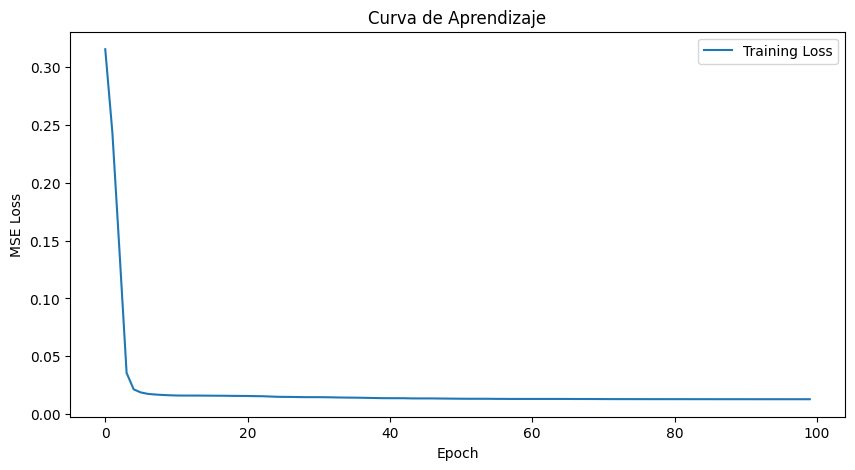

In [9]:
model = STDenseNet(LEN_CLOSE, LEN_PERIOD, NB_FLOW).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

print(f"Iniciando entrenamiento en: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU Activa: {torch.cuda.get_device_name(0)}")
print("Nota: Si el uso de GPU no sube inmediatamente, es porque se están cargando datos en RAM.")

train_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    for xc, xd, y in train_loader:
        xc, xd, y = xc.to(DEVICE), xd.to(DEVICE), y.to(DEVICE)
        
        optimizer.zero_grad()
        output = model(xc, xd)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    scheduler.step()
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.6f}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Curva de Aprendizaje')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

## 5. Interpretación de Resultados

### 5.1. Métricas de Evaluación
Para evaluar el rendimiento, primero se **desnormalizan** las predicciones para volver a la escala original de tráfico (número de SMS).

$$ \hat{X}_{orig} = \hat{X}_{norm} \cdot (Max - Min) + Min $$

Se calculan las siguientes métricas:

1.  **RMSE (Root Mean Squared Error)**: Error cuadrático medio. Penaliza más los errores grandes.
    $$ RMSE = \sqrt{\frac{1}{M} \sum (\hat{x}_{orig} - x_{orig})^2} $$

2.  **MAE (Mean Absolute Error)**: Error absoluto medio. Es más robusto a outliers y fácil de interpretar (error promedio en SMS).
    $$ MAE = \frac{1}{M} \sum |\hat{x}_{orig} - x_{orig}| $$

3.  **R2 Score**: Coeficiente de determinación. Indica qué tan bien las predicciones se ajustan a los datos reales (1.0 es perfecto).

### 5.2. Visualización
*   **Scatter Plot**: Gráfico de dispersión de Predicción vs Realidad. Idealmente, los puntos deberían alinearse en la diagonal.
*   **Distribución de Errores**: Histograma de los residuos. Debería estar centrado en 0.
*   **Mapa de Calor de Error**: Muestra dónde se concentran los errores espacialmente.
*   **Serie Temporal**: Comparación visual de la predicción y la realidad a lo largo del tiempo para una celda específica.

Iniciando evaluación...
Resultados de Evaluación:
RMSE: 709.5107
MAE:  94.8380
R2:   -456.5720


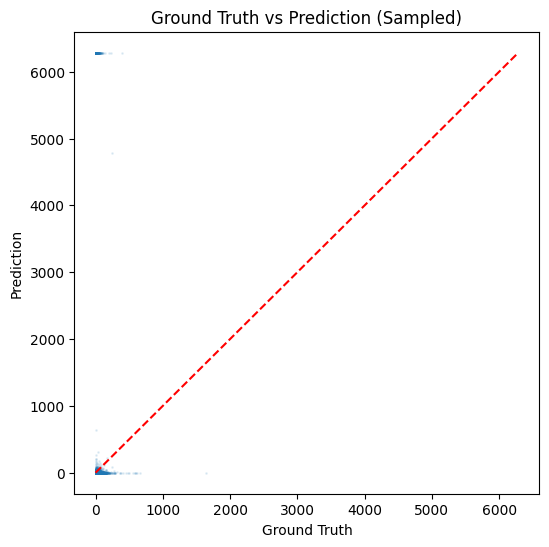

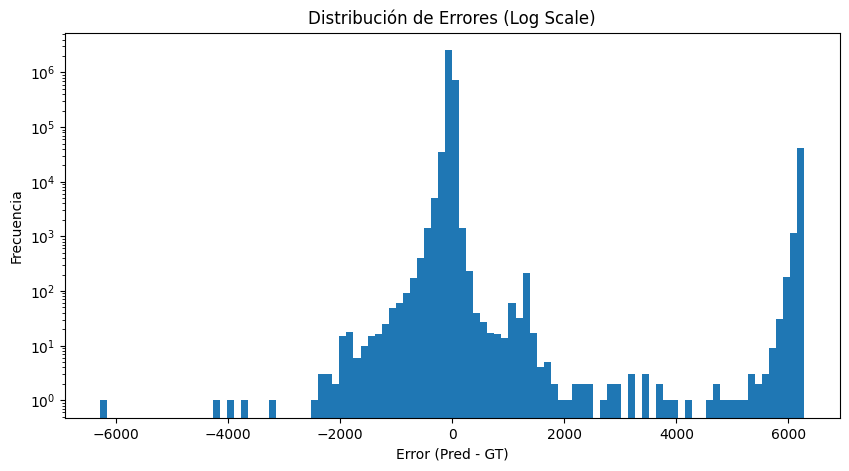

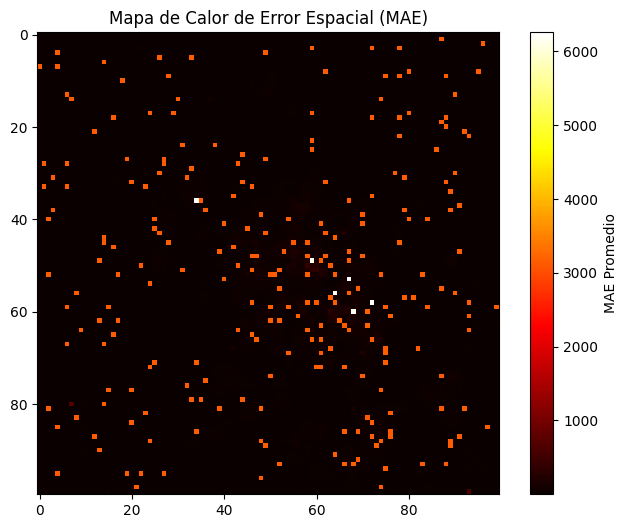

Visualizando serie temporal para la celda con más tráfico: (50, 58)


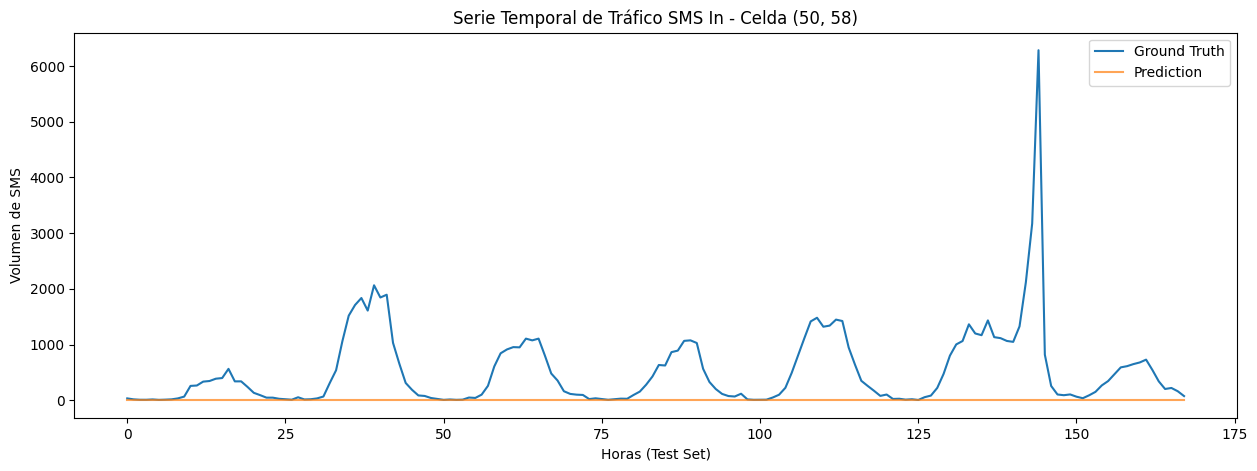

In [10]:
model.eval()
predictions = []
ground_truth = []

print("Iniciando evaluación...")
with torch.no_grad():
    for xc, xd, y in test_loader:
        xc, xd, y = xc.to(DEVICE), xd.to(DEVICE), y.to(DEVICE)
        output = model(xc, xd)
        predictions.append(output.cpu().numpy())
        ground_truth.append(y.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
ground_truth = np.concatenate(ground_truth, axis=0)

# Rescalado Inverso (Denormalization)
preds_rescaled = predictions * (mmn_max - mmn_min) + mmn_min
gt_rescaled = ground_truth * (mmn_max - mmn_min) + mmn_min

# --- MÉTRICAS ---
mse = mean_squared_error(gt_rescaled.flatten(), preds_rescaled.flatten())
rmse = np.sqrt(mse)
mae = mean_absolute_error(gt_rescaled.flatten(), preds_rescaled.flatten())
r2 = r2_score(gt_rescaled.flatten(), preds_rescaled.flatten())

print(f"Resultados de Evaluación:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")

# --- VISUALIZACIONES ---

# 1. Scatter Plot (Muestreado)
plt.figure(figsize=(6, 6))
sample_idx = np.random.choice(gt_rescaled.flatten().shape[0], 10000, replace=False)
plt.scatter(gt_rescaled.flatten()[sample_idx], preds_rescaled.flatten()[sample_idx], alpha=0.1, s=1)
plt.plot([gt_rescaled.min(), gt_rescaled.max()], [gt_rescaled.min(), gt_rescaled.max()], 'r--')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Ground Truth vs Prediction (Sampled)')
plt.show()

# 2. Distribución de Errores
errors = preds_rescaled.flatten() - gt_rescaled.flatten()
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=100, log=True)
plt.title('Distribución de Errores (Log Scale)')
plt.xlabel('Error (Pred - GT)')
plt.ylabel('Frecuencia')
plt.show()

# 3. Mapa de Calor de Error Espacial (MAE)
# Promedio sobre Tiempo y Canales
mae_spatial = np.mean(np.abs(preds_rescaled - gt_rescaled), axis=(0, 1))

plt.figure(figsize=(8, 6))
plt.imshow(mae_spatial, cmap='hot')
plt.colorbar(label='MAE Promedio')
plt.title('Mapa de Calor de Error Espacial (MAE)')
plt.show()

# 4. Serie Temporal para la Celda con más Tráfico
total_traffic = np.sum(gt_rescaled, axis=(0, 1))
y_max, x_max = np.unravel_index(np.argmax(total_traffic), total_traffic.shape)

print(f"Visualizando serie temporal para la celda con más tráfico: ({y_max}, {x_max})")

gt_series = gt_rescaled[:, 0, y_max, x_max] # Channel 0 (SMS In)
pred_series = preds_rescaled[:, 0, y_max, x_max]

plt.figure(figsize=(15, 5))
plt.plot(gt_series, label='Ground Truth')
plt.plot(pred_series, label='Prediction', alpha=0.7)
plt.title(f'Serie Temporal de Tráfico SMS In - Celda ({y_max}, {x_max})')
plt.xlabel('Horas (Test Set)')
plt.ylabel('Volumen de SMS')
plt.legend()
plt.show()